# D - Isotope Combinations

Objective
-
The purpose of this notebook is to reconcile the information we have developed thus far with the naturally occuring amounts of each isotope in each detector material.

Natural silicon has three isotopes and corresponding concentrations:
- Silicon-28 - 92.22%
- Silicon-30 - 4.69%
- Silicon-31 - 3.09%

Natural germanium has five isotopes and corresponding concentrations:
- Germanium-70 - 20.57%
- Germanium-72 - 27.45%
- Germanium-73 - 7.75%
- Germanium-74 - 36.50%
- Germanium-76 - 7.73%

Values taken from [National Isotope Development Center - Silicon][National Isotope Development Center - Silicon] and [National Isotope Development Center - Germanium][National Isotope Development Center - Germanium]

[National Isotope Development Center - Silicon]: https://www.isotopes.gov/products/silicon "NIDC - Silicon Documentaion"
[National Isotope Development Center - Germanium]: https://www.isotopes.gov/products/germanium "NIDC - Germanium Documentaion"

Libraries and Style Files
-------------------------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles

# Extend Python path to include local module directory
import sys
sys.path.append('../python/')

# Install packages if not already available
import importlib.util
import subprocess

def install_if_missing(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("periodictable")
install_if_missing("pyteomics")

# Standard scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as co
from scipy import integrate
from scipy.interpolate import interp1d

# Project-specific modules
import flux_recoil_spec as frs

We will now encode the isotopic values for Silicon and Germanium in Python:

In [2]:
# Natural abundances of silicon isotopes (in fractional form)
si_isotopes = {
    28: 0.9222,
    29: 0.0464,
    30: 0.0309
}

# Natural abundances of germanium isotopes (in fractional form)
ge_isotopes = {
    70: 0.2057,
    72: 0.2745,
    73: 0.0775,
    74: 0.3650,
    76: 0.0773
}

Define Flux Interpolator

In [3]:
# Load SNOLAB flux data from the flux_recoil_spec module
E_flux, F_flux, *_ = frs.SNOLAB_flux()  # Energy [MeV], Flux [n/cm^2/s/MeV]

# Create an interpolator for continuous access to flux
flux_interp = interp1d(E_flux, F_flux, bounds_error=False, fill_value=0.0)

def realflux(En):
    return flux_interp(En)

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01


Compute Recoil Spectrum for Each Isotope

In [4]:
def dsigdErNE(En, Er, M=None):
    """
    Differential cross-section dσ/dEr as a flat approximation up to Emax.

    Parameters:
    - En: neutron energy in keV
    - Er: recoil energy in keV
    - M: isotope mass in g/mol (optional for now)

    Returns:
    - Cross section in cm²/keV
    """
    Emax = frs.Emax(En)
    if Er < Emax:
        return frs.sigtot / Emax  # Flat distribution
    else:
        return 0.0

def Enmin(Er, A):
    """
    Minimum neutron energy [keV] required to produce recoil energy Er [keV]
    for a nucleus with mass number A.
    """
    m_n = 931.5  # MeV/c^2
    M = A * 931.5  # MeV/c^2
    term = (M + m_n)**2 / (2 * M * m_n)
    En_min = np.sqrt(Er * term)  # result in keV
    return En_min

def get_recoil_spectrum(isotope_mass):
    """
    Calculates the differential recoil event rate dR/dEr for a given isotope.
    Returns a tuple (erange, dru_vec) with energies and rates.
    """
    erange = np.linspace(0.0, 20.0, 200)  # recoil energies in keV
    dru_vec = []

    for Er in erange:
        def integrand(En):
            flux = realflux(En)
            sig = frs.dsigdErNE(En * 1000, Er, isotope_mass)  # En [MeV] -> keV
            return flux * sig

        En_min = frs.Enmin(Er) / 1000  # MeV
        En_max = 10  # MeV cutoff

        integral, _ = integrate.quad(integrand, En_min, En_max, limit=1000)
        dru = 14 * (co.N_A / isotope_mass) * integral
        dru_vec.append(dru)

    dru_vec = np.array(dru_vec)
    dru_vec *= 1000 * 365 * 24 * 60 * 60  # convert to [counts / kg / yr / keV]
    return erange, dru_vec

Combine Spectra by Isotopic Abundance

In [5]:
def compute_natural_spectrum(isotope_dict):
    """
    Combines the spectra of individual isotopes using weighted natural abundance.
    """
    combined_spectrum = None
    erange = None

    for A, abundance in isotope_dict.items():
        mass = A  # g/mol
        erange, spec = get_recoil_spectrum(mass)
        weighted_spec = abundance * spec

        if combined_spectrum is None:
            combined_spectrum = weighted_spec
        else:
            combined_spectrum += weighted_spec

    return erange, combined_spectrum

# Compute for natural silicon
si_erange, si_spectrum = compute_natural_spectrum(si_isotopes)

Plot

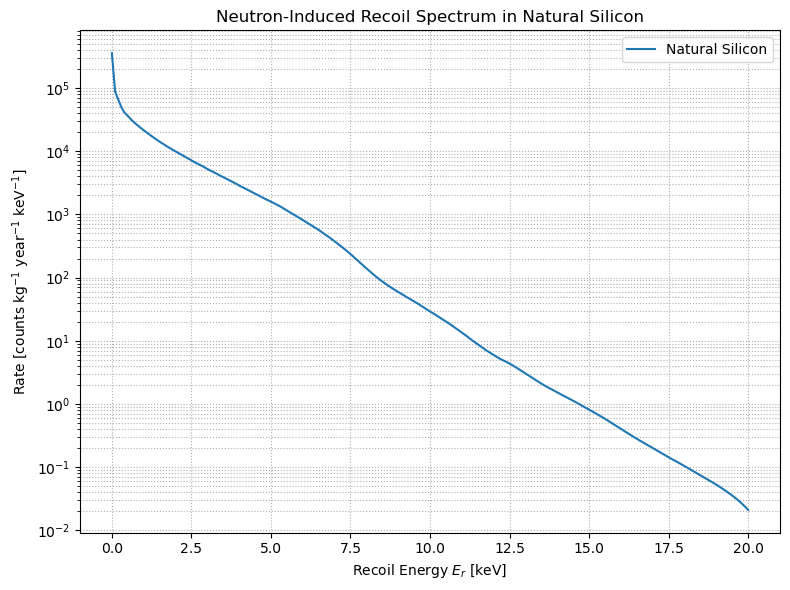

In [6]:
plt.figure(figsize=(8,6))
plt.plot(si_erange, si_spectrum, label='Natural Silicon')
plt.yscale('log')
plt.xlabel('Recoil Energy $E_r$ [keV]')
plt.ylabel('Rate [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
plt.title('Neutron-Induced Recoil Spectrum in Natural Silicon')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()